## Setup imports

In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import random
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
from tqdm.notebook import tqdm

print_config()

2025-02-28 16:39:23.183929: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 16:39:23.235471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 16:39:23.235508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 16:39:23.237017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 16:39:23.246696: I tensorflow/core/platform/cpu_feature_guar

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.15.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALL

## Setup data directory

In [2]:
# data_path = "data/"
data_path = r"../../"
train_path = data_path + "NCT-CRC-HE-100K"
test_path = data_path + "CRC-VAL-HE-7K"

## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=42)

## Train data

In [4]:
class_names = sorted(x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(train_path, class_names[i], x) for x in os.listdir(os.path.join(train_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 100000
Image dimensions: 224 x 224
Label names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Label counts: [10407, 10566, 11512, 11557, 8896, 13536, 8763, 10446, 14317]


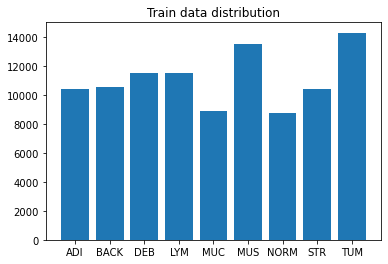

In [5]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Train data distribution")
plt.show()

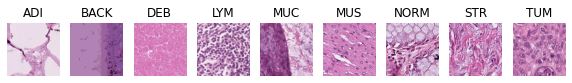

In [6]:
# Plot an image from each class
plt.figure(figsize=(10, 5))
for i in range(num_class):
    plt.subplot(1, num_class, i + 1)
    plt.imshow(PIL.Image.open(image_files[i][0]))
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

## Undersampling: Dataset Balancing

In [7]:
num_min_class = min(num_each)
print(f"Class with less samples: {class_names[np.argmin(num_each)]} with {num_min_class} images")
print("---")
balanced_image_files_list = []
balanced_image_class = []
for i in range(num_class):
    print(f"{class_names[i]:<10} Taking {num_min_class} from initial {len(image_files[i])} samples")
    balanced_image_files_list.extend(random.sample(image_files[i], num_min_class))
    balanced_image_class.extend([i] * num_min_class)


Class with less samples: NORM with 8763 images
---
ADI        Taking 8763 from initial 10407 samples
BACK       Taking 8763 from initial 10566 samples
DEB        Taking 8763 from initial 11512 samples
LYM        Taking 8763 from initial 11557 samples
MUC        Taking 8763 from initial 8896 samples
MUS        Taking 8763 from initial 13536 samples
NORM       Taking 8763 from initial 8763 samples
STR        Taking 8763 from initial 10446 samples
TUM        Taking 8763 from initial 14317 samples


## Prepare training and validation splits

In [8]:
val_frac = 0.2
length = len(balanced_image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

val_split = int(val_frac * length)
val_indices = indices[:val_split]
train_indices = indices[val_split:]

train_x = [balanced_image_files_list[i] for i in train_indices]
train_y = [balanced_image_class[i] for i in train_indices]
val_x = [balanced_image_files_list[i] for i in val_indices]
val_y = [balanced_image_class[i] for i in val_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}")

Training count: 63094, Validation count: 15773


## Define transforms, Dataset and Dataloader to pre-process data

In [9]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

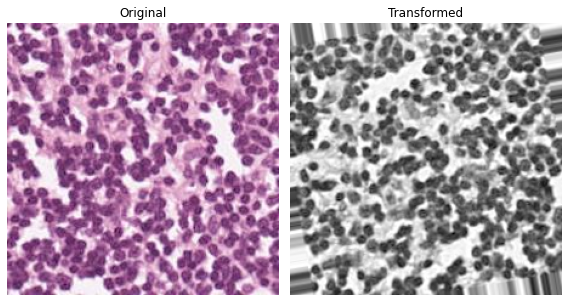

In [10]:
# Example of original and transformed image
plt.figure(figsize=(8, 8))

trans = train_transforms(train_x[0])
orig = PIL.Image.open(train_x[0])

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(trans[0], cmap="gray")
plt.title("Transformed")
plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
class TissuesDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = TissuesDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=10)
print("Number of train batches:", len(train_loader))

val_ds = TissuesDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=10)
print("Number of validation batches:", len(val_loader))

Number of train batches: 986
Number of validation batches: 247


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU device, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class, pretrained=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

Device: cuda
NVIDIA L40S


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
#    print("-" * 10)
#    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=False)
    for batch_data in train_progress:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
#    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation", leave=False)
            for val_data in val_progress:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(data_path, "best_metric_model.pth"))
#                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

Epoch 1 Training:   0%|          | 0/986 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/247 [00:00<?, ?it/s]

current epoch: 1 current AUC: 0.9992 current accuracy: 0.9765 best AUC: 0.9992 at epoch: 1


Epoch 2 Training:   0%|          | 0/986 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/247 [00:00<?, ?it/s]

current epoch: 2 current AUC: 0.9997 current accuracy: 0.9867 best AUC: 0.9997 at epoch: 2


Epoch 3 Training:   0%|          | 0/986 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/247 [00:00<?, ?it/s]

current epoch: 3 current AUC: 0.9999 current accuracy: 0.9899 best AUC: 0.9999 at epoch: 3


Epoch 4 Training:   0%|          | 0/986 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/247 [00:00<?, ?it/s]

current epoch: 4 current AUC: 0.9999 current accuracy: 0.9921 best AUC: 0.9999 at epoch: 4
train completed, best_metric: 0.9999 at epoch: 4


## Plot the loss and metric

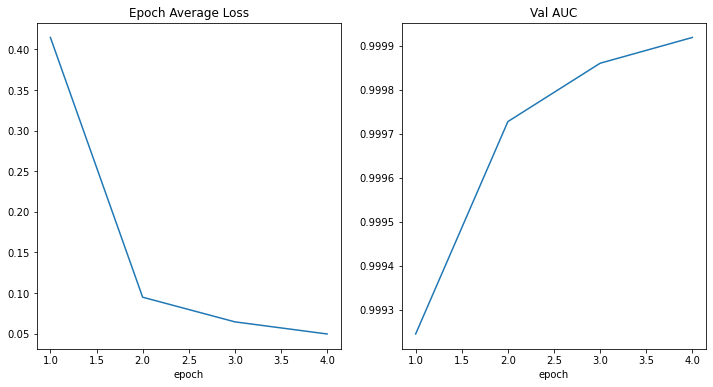

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluation with test data

In [22]:
class_names = sorted(x for x in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(test_path, class_names[i], x) for x in os.listdir(os.path.join(test_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 7180
Image dimensions: 224 x 224
Label names: ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Label counts: [1338, 847, 339, 634, 1035, 592, 741, 421, 1233]


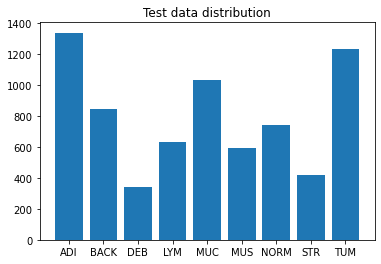

In [23]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Test data distribution")
plt.show()

In [24]:
test_ds = TissuesDataset(image_files_list, image_class, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=10)

In [27]:
model.load_state_dict(torch.load(os.path.join("./models", "best_metric_model-balanced.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

/tmp/ipykernel_2167819/1148934771.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("./models", "best_metric_model-balanced.p

In [28]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

         ADI     0.9932    0.9828    0.9880      1338
        BACK     1.0000    0.9953    0.9976       847
         DEB     0.8629    0.9469    0.9030       339
         LYM     0.9950    0.9353    0.9642       634
         MUC     0.9246    0.9952    0.9586      1035
         MUS     0.7802    0.8936    0.8331       592
        NORM     0.9470    0.9879    0.9670       741
         STR     0.9706    0.6271    0.7619       421
         TUM     0.9892    0.9692    0.9791      1233

    accuracy                         0.9501      7180
   macro avg     0.9403    0.9259    0.9280      7180
weighted avg     0.9538    0.9501    0.9490      7180



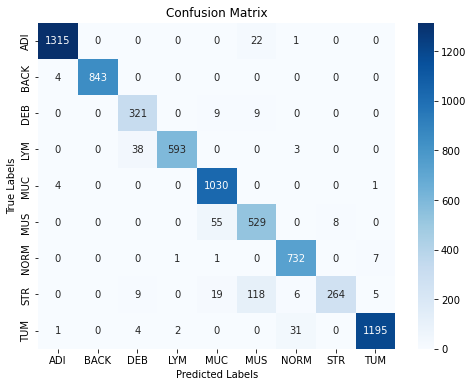

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Define class names
class_names = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"]

# Example confusion matrix (replace with your actual values)
cm = confusion_matrix(y_true, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Activation maps

In [125]:
import torch

# densenet 2d
from monai.networks.nets import DenseNet121
from monai.visualize import CAM, GradCAMpp

model.to(device)
model.load_state_dict(torch.load(os.path.join("./models", "best_metric_model-balanced.pth"), weights_only=True))
model.eval()
model_2d = model

gradcampp = GradCAMpp(model, target_layers="class_layers.relu")
cam = CAM(nn_module=model_2d, target_layers="class_layers.relu", fc_layers="class_layers.out")

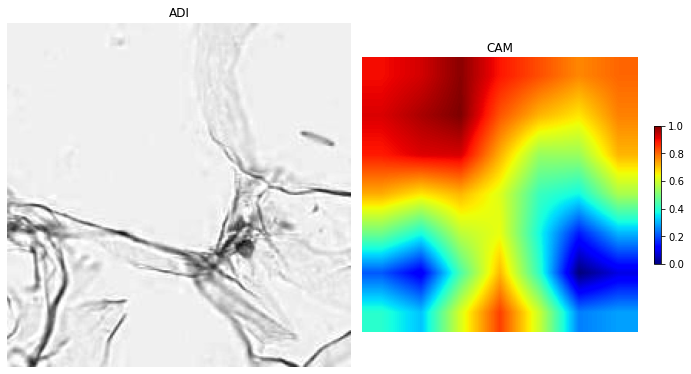

In [134]:
idx = 32
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        break
    result = cam(x=test_images[idx].unsqueeze(0))
    #result = gradcampp(x=test_images[idx].unsqueeze(0))
    result_label = class_names[test_labels[idx].item()]
    
    
ax1.imshow(test_images.cpu().numpy()[idx][0], cmap="gray")
ax1.set_title(result_label)
activation_map = ax2.imshow(result.cpu().numpy()[0][0], cmap="jet", alpha=1)
ax2.set_title("CAM")
fig.colorbar(activation_map, ax=ax2, shrink=0.25)

ax1.axis("off"), ax2.axis("off")
plt.tight_layout()
plt.show()

In [135]:
test_labels #  porque todas ADI??

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

[aqui explican que lo azul es lo importante](https://github.com/Project-MONAI/MONAI/discussions/4086)

**Understand Network Predictions Using Occlusion**

This example shows how to use occlusion sensitivity maps to understand why a deep neural network makes a classification decision. Occlusion sensitivity is a simple technique for understanding which parts of an image are most important for a deep network's classification. You can measure a network's sensitivity to occlusion in different regions of the data using small perturbations of the data. Use occlusion sensitivity to gain a high-level understanding of what image features a network uses to make a particular classification, and to provide insight into the reasons why a network can misclassify an image.

Deep Learning Toolbox provides the occlusionSensitivity function to compute occlusion sensitivity maps for deep neural networks that accept image inputs. The occlusionSensitivity function perturbs small areas of the input by replacing it with an occluding mask, typically a gray square. The mask moves across the image, and the change in probability score for a given class is measured as a function of mask position. You can use this method to highlight which parts of the image are most important to the classification: when that part of the image is occluded, the probability score for the predicted class will fall sharply.

## Occlusion Sensitivity

## GRAD-CAM